# Import packages

Using Example_1pop.ipyn as a template

Goals: Use my_loss_norm_poiss as cost function
    - either need to update possible 'orth' values, add new param
    - 'orth' determines 'LowROrth' or 'LowRNorm'. Don't plan to update this for now
    - Going to add a new param for now with a default value, hopefully will not need to update function calls


TODO: look more into softplus, verify that values should always be positive
Set lam sparse and orthog to be 1 and run 0 iterations
    want to alter it so term 2 and 3 are around 10% of term 1
Make sure orth is false when running model
    
Progress
    - Added poisson loss
    - found ballpark values for sparse and orthog using 1pop simulated data

Switch to the other data simulation instead of 1pop simulation to hopefully avoid neg values
Adding Convolutional filters and then smoothing in cost function might be next step

In [147]:
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.linalg import orth
import time

from sca.models import fit_sca, weighted_pca, weighted_rrr
from sca.util import get_sample_weights

In [148]:
# %load_ext autoreload
# %autoreload 2

# Simulate data

In [149]:
#Function that creates a sine wave for a given amount of time (T),
#where the number of cycles (c) occurs during that time
def create_sine(T,c):
    tau=T/(2*np.pi)/c
    return np.sin(np.arange(0,T)/tau)

def Gaussian(sig=1, x_width=10):
    x_width = 10    # number of bins to evaluate Gaussian at 
    x = np.arange(-x_width//2, x_width//2)
    gaussian = np.exp(-(x/sig)**2/2)
    return gaussian

#### Generate the simulated data X0, which is size [Time x Num_neurons]

In [150]:
np.random.seed(0) #To get the same simulated data
'''
T=1200 #Time
N=50 #Number of neurons
R_sim=7 #Number of dimensions in lowD representations

#Orthogonal matrix that projects low dimensional space to full neural space
V_tmp=orth(npr.randn(R_sim,N).T).T 

#Create low dimensional space
Z=np.zeros([T,R_sim])
for i in range(7):
    Z[150*i:150*i+300,i]=create_sine(300,i+1)

#Create high-dimensional neural activity    
b=npr.randn(N) #Offset of neurons
X0=Z@V_tmp[:R_sim,:]+b #Project into high-dimensional space and add offset
X0=X0+.1*npr.randn(X0.shape[0],X0.shape[1]) #Add noise
'''
T=900           # Time
N=50            # Number of neurons
R_sim=5         # Number of latent dimensions
dts=0.01        # Firing rate will initially be in seconds -> this converts to spikes per 10 ms
avg_fr=100      # The desired average firing rate in spikes / second
std=5           # Stddev of Gaussian used to smooth spike counts - units are dts*seconds

#Create low dimensional space
Z=np.zeros([T,R_sim])
for i in range(R_sim):
    Z[150*i:150*i+300,i]=create_sine(300,i+1)

# Plot our created ground-truth latent dimensions
for dim in range(R_sim):
    plt.subplot(R_sim,1,dim+1)
    plt.plot(Z[:,dim])
    plt.ylabel(f"$z_{dim}$")
plt.clf()

# Orthogonal matrix that projects low dimensional space to full "neural" space (firing rates)
V_tmp=orth(npr.randn(R_sim,N).T).T

# Project latents up into firing-rate space (num_spikes per second)
X_fr = Z @ V_tmp

# We can't have negative firing rates
X_fr -= X_fr.min(axis=0)

# Scale firing rates s.t. we get desired average firing rate across all "neurons"
X_fr *= avg_fr/X_fr.mean()

# Convert firing rates to spike counts drawn from a Poisson
X_spikes = npr.poisson(X_fr * dts)

# Make Gaussian kernel for smoothing the spike counts
gaussian = Gaussian(sig=std)

# Smooth spike counts w.r.t. time
X_smoothed = []
for x in X_spikes.T:
    X_smoothed.append(np.convolve(x, gaussian, mode="full"))
X_smoothed = np.stack(X_smoothed).T

# Plot example neuron before and after smoothing
plt.plot(X_smoothed[:,0], label='Post-smooth')
plt.plot(X_spikes[:,0], label='Pre-smooth')
plt.legend()
# plt.show()
plt.clf()


<Figure size 640x480 with 0 Axes>

# Preprocess data (optional)

I have found that the method usually works better when zero-centering the data.

In this specific example, if you don't zero-center the data, it will take ~10000 iterations to converge to the ground truth, rather than ~2000.

In [151]:
# X =np.copy(X0)
# X=np.copy(X0-np.mean(X0,axis=0)[None,:])

X =np.copy(X_smoothed)
# X =np.copy(X_spikes)
# X=np.copy(X_smoothed-np.mean(X_smoothed,axis=0)[None,:])

# Set required model parameters

In [152]:
#Number of dimensions in the low-D model you're fitting
R_est=8

# Set some optional model parameters

All of these have default values, so it's not essential to set them.

In [153]:
#Number of epochs of model fitting
n_epochs=3000

#Learning rate of model fitting
lr=.001


#I would recommend using the default lambda parameters, at least to start. 
#When running SCA, it will print what the default values are for the given dataset

#Strength of the sparsity penalty
# lam_sparse=.1
lam_sparse = 0.1
#Strength of the orthogonality penality (Note - This is only used in the version without a hard orthogonality constraint)
# lam_orthog=1
# lam_orthog = 1.5e17
lam_orthog = 150

#Initialization of weights - can be 'pca' or 'rand'
init='pca'

In [154]:
#How much to weight each data point in time
#(this can be helpful for making sure dimensions still aim to explain time points with low activity)

sample_weights=np.ones([X.shape[0],1]) #Weight equally

# sample_weights=get_sample_weights(X) #Weight inversely to norm of activity at each time point

# Fit PCA Model (for comparison)

In [155]:
#Fit weighted PCA
#Note that this function does not automatically subtract the mean from the data (as in many PCA functions)
U_est_pca,V_est_pca = weighted_pca(X,R_est,sample_weights)

#Get the low dimensional representation (the principal components)
pca_latent = X@U_est_pca

# Fit SCA Model
Note that the version of SCA that has orth=False (which uses an orthogonality penalty instead of a hard constraint) runs faster

Using device cpu


100%|██████████| 3000/3000 [00:06<00:00, 467.09it/s]


Text(0.5, 1.0, 'Loss over training')

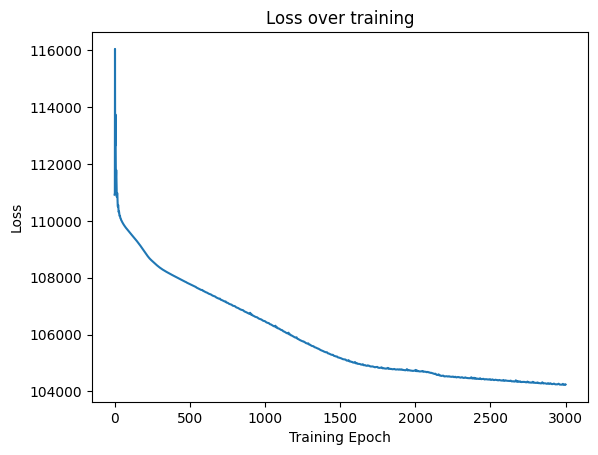

In [156]:
#Fit SCA with orthogonality constraint without all the optional parameters
# model, latent, y_pred, losses = fit_sca(X=X,R=R_est)

#Fit SCA with orthogonality constraint
# model, latent, y_pred, losses = fit_sca(X=X,R=R_est,sample_weight=sample_weights,lam_sparse=lam_sparse,lr=lr,n_epochs=n_epochs, init=init)

#Fit SCA with orthogonality penalty (rather than constraint) without all the optional parameters
# TODO: this one uncommented before: 
# model, latent, y_pred, losses = fit_sca(X=X,R=R_est,orth=False)

#Fit SCA with orthogonality penalty (rather than constraint)
# model, latent, y_pred, losses = fit_sca(X=X,R=R_est,orth=False,sample_weight=sample_weights,lam_sparse=lam_sparse,lr=lr,n_epochs=n_epochs,lam_orthog=lam_orthog, init=init)

#Fit SCA with orthogonality penalty (rather than constraint) and using Poisson loss function
# model, latent, y_pred, losses = fit_sca(X=X,R=R_est,orth=False,poisson=True) 
# model, latent, y_pred, losses = fit_sca(X=X,R=R_est,orth=False,poisson=True, lam_sparse= lam_sparse, lam_orthog=lam_orthog, lr=1e-2)
model, latent, y_pred, losses = fit_sca(X=X,R=R_est,orth=False,poisson=True, lam_sparse= lam_sparse, lam_orthog=lam_orthog, lr=1e-2)



#Get the low dimensional representation
sca_latent=latent.detach().numpy()

#Plot the loss over all iterations
plt.figure()
plt.plot(losses)
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Loss over training')

# Plot the loss over the last 100 iterations (to see if it has truly hit a plateau)
# plt.figure()
# plt.plot(losses[-100:-1])
# plt.xlabel('Training Epoch')
# plt.ylabel('Loss')

In [163]:
# Plot the loss over the last 100 iterations (to see if it has truly hit a plateau)
# plt.figure()
# plt.plot(losses[-100:-1])
# # plt.plot(losses[:100])
# plt.xlabel('Training Epoch')
# plt.ylabel('Loss')

# Plot results

### Plot unordered lowD representations

Text(0.5, 1.0, 'PCA LowD Projections')

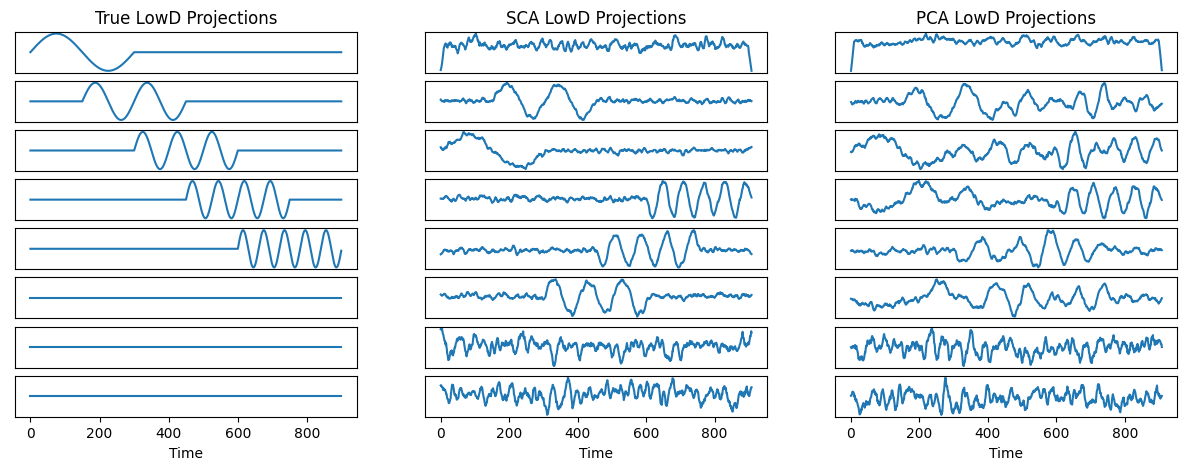

In [158]:
#Ground truth
Z_extra=np.zeros([T,R_est])
Z_extra[:,:R_sim]=Z


plt.figure(figsize=(15,5))
for i in range(R_est):
    
    #Plot ground truth
    plt.subplot(R_est,3,3*i+1)
    plt.plot((Z_extra)[:,i]) 
    
    # plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
    
    # Plot SCA results
    plt.subplot(R_est,3,3*i+2)
    plt.plot(sca_latent[:,i])
    
    # plt.ylim([-1.1, 1.1])
    plt.yticks([])    
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(R_est,3,3*i+3)
    plt.plot(pca_latent[:,i])
    
    # plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')        

#Titles
plt.subplot(R_est,3,1)
plt.title('True LowD Projections')

plt.subplot(R_est,3,2)
plt.title('SCA LowD Projections')

plt.subplot(R_est,3,3)
plt.title('PCA LowD Projections')


In [159]:
''' 
Y axis limits for SCA might show that the last 2 plots are just a little bit of noise
'''

' \nY axis limits for SCA might show that the last 2 plots are just a little bit of noise\n'

### Order low-dimensional representations by time of maximum variance explained by that dimension.

In [160]:
#Amount of squared activity each dimension explains in PCA
infs_pca=[np.sum((pca_latent[:,i:i+1]@V_est_pca[i:i+1,:])**2,axis=1) for i in range(R_est)]

#Amount of squared activity each dimension explains in SCA
V_est_sca=model.fc2.weight.detach().numpy()
infs_sca=[np.sum((sca_latent[:,i:i+1]@V_est_sca[:,i:i+1].T)**2,axis=1) for i in range(R_est)]

#Find the time point of each dimension that has the largest squared activity explained
max_array_pca=[np.argmax(infs_pca[i]) for i in range(R_est)]
max_array_sca=[np.argmax(infs_sca[i]) for i in range(R_est)]

#Order dimensions
pca_order=np.argsort(np.array(max_array_pca))
sca_order=np.argsort(np.array(max_array_sca))

#### Plot!

Text(0.5, 1.0, 'PCA LowD Projections')

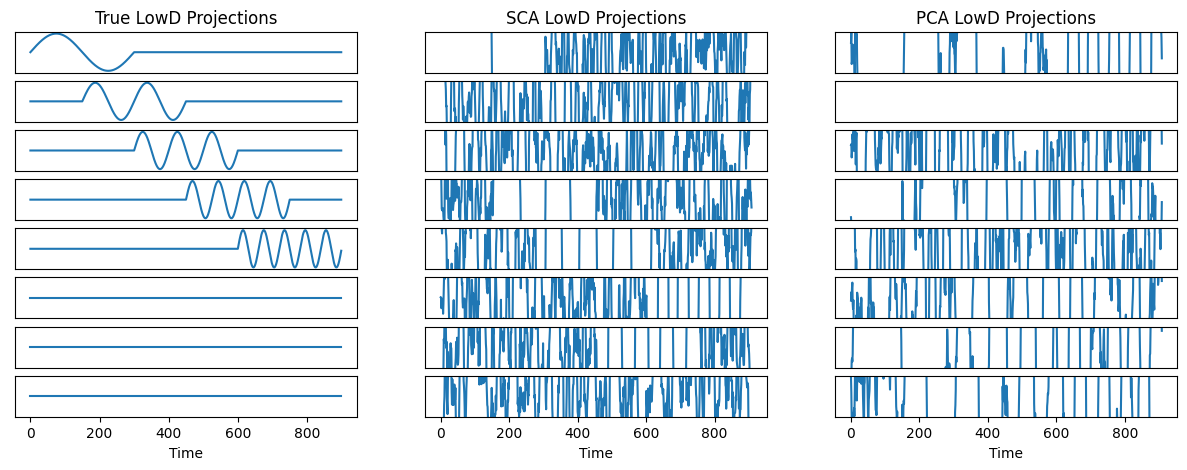

In [161]:
#Ground truth
Z_extra=np.zeros([T,R_est])
Z_extra[:,:R_sim]=Z


plt.figure(figsize=(15,5))
for i in range(R_est):
    
    #Plot ground truth
    plt.subplot(R_est,3,3*i+1)
    plt.plot((Z_extra)[:,i]) 
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
    
    # Plot SCA results
    plt.subplot(R_est,3,3*i+2)
    plt.plot(sca_latent[:,sca_order[i]])
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])    
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(R_est,3,3*i+3)
    plt.plot(pca_latent[:,pca_order[i]])
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')        

#Titles
plt.subplot(R_est,3,1)
plt.title('True LowD Projections')

plt.subplot(R_est,3,2)
plt.title('SCA LowD Projections')

plt.subplot(R_est,3,3)
plt.title('PCA LowD Projections')


### Look at how orthogonal the projection is
This is relevant when not constraining orthogonality

It will show how orthogonal each of the latent dimensions are to each other

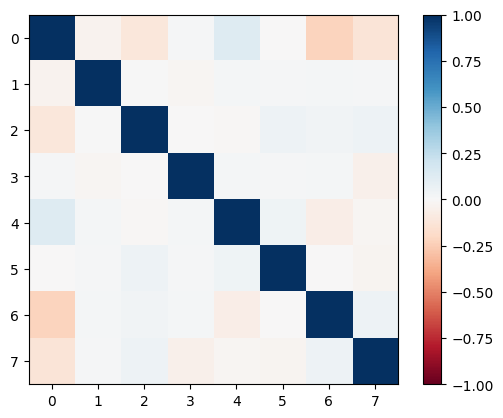

In [162]:
product=model.fc2.weight.detach().numpy().T@model.fc2.weight.detach().numpy()
plt.imshow(product,clim=[-1,1],cmap='RdBu')
plt.colorbar()